- Training and Testing with (IMU + ECG) measurements (Movesense dataset)
 


In [1]:
# Importing libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
import tensorflow as tf
import keras 
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.signal import butter, filtfilt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the combined file (imu + ecg) 52Hz of the movesense, performed on microsoft excel
## file location
file='C:/Users/val-c/Desktop/combined_file52.csv'
movement_data=pd.read_csv(file)
movement_data #display df

,x,y,z,gx,gy,gz,sample,classes
0,1.081595,9.786994,0.844697,-7.77,-18.550000,-6.30,-227.000000,1
1,1.131846,9.736743,0.940413,-7.91,-20.160000,-7.84,-230.403846,1
2,1.103131,9.645813,0.949985,-8.26,-22.120000,-9.10,-168.192308,1
3,1.060058,9.595561,0.897341,-8.82,-24.430000,-10.15,-135.461538,1
4,1.076809,9.454380,0.909305,-9.66,-26.880001,-10.71,369.384615,1
...,...,...,...,...,...,...,...,...
33915,2.500589,9.341913,0.648478,8.47,-36.750000,2.31,345.211539,9
33916,2.459909,9.490273,0.550369,7.70,-37.100000,2.24,-166.692308,9
33917,2.368979,9.578811,0.454653,7.42,-36.470000,3.08,-355.692308,9
33918,2.474267,9.597955,0.519261,7.98,-35.560000,3.08,-400.076923,9


In [3]:
# conversion of the ecg sample to mV
## defining vaiables below:
peak_to_peak_volt = 60  # dynamic range/full-scale input voltage in mV
digital_resolution = 15  # resolution
full_scale_digital_value = 2 ** digital_resolution  # number of steps in the digital output
full_scale_input_volt = peak_to_peak_volt / 2  # average voltage level in mV
digital_output_value = movement_data['sample']  # digital output values of ECG measurements
# Convert digital output values to mV
movement_data.insert(7, 'ecg_mV', (digital_output_value / full_scale_digital_value) * full_scale_input_volt) #put the new field to index position
# Display the df
movement_data.head() # display first-five rows

,x,y,z,gx,gy,gz,sample,ecg_mV,classes
0,1.081595,9.786994,0.844697,-7.77,-18.550000,-6.30,-227.000000,-0.207825,1
1,1.131846,9.736743,0.940413,-7.91,-20.160000,-7.84,-230.403846,-0.210941,1
2,1.103131,9.645813,0.949985,-8.26,-22.120000,-9.10,-168.192308,-0.153985,1
3,1.060058,9.595561,0.897341,-8.82,-24.430000,-10.15,-135.461538,-0.124019,1
4,1.076809,9.454380,0.909305,-9.66,-26.880001,-10.71,369.384615,0.338182,1


In [4]:
# drop 'sample' column 
movement_data=movement_data.drop(['sample'],axis=1)
movement_data # display dataframe

,x,y,z,gx,gy,gz,ecg_mV,classes
0,1.081595,9.786994,0.844697,-7.77,-18.550000,-6.30,-0.207825,1
1,1.131846,9.736743,0.940413,-7.91,-20.160000,-7.84,-0.210941,1
2,1.103131,9.645813,0.949985,-8.26,-22.120000,-9.10,-0.153985,1
3,1.060058,9.595561,0.897341,-8.82,-24.430000,-10.15,-0.124019,1
4,1.076809,9.454380,0.909305,-9.66,-26.880001,-10.71,0.338182,1
...,...,...,...,...,...,...,...,...
33915,2.500589,9.341913,0.648478,8.47,-36.750000,2.31,0.316051,9
33916,2.459909,9.490273,0.550369,7.70,-37.100000,2.24,-0.152611,9
33917,2.368979,9.578811,0.454653,7.42,-36.470000,3.08,-0.325646,9
33918,2.474267,9.597955,0.519261,7.98,-35.560000,3.08,-0.366281,9


In [5]:
# Display info of the dataframe
movement_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33920 entries, 0 to 33919
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   x        33920 non-null  float64
 1   y        33920 non-null  float64
 2   z        33920 non-null  float64
 3   gx       33920 non-null  float64
 4   gy       33920 non-null  float64
 5   gz       33920 non-null  float64
 6   ecg_mV   33920 non-null  float64
 7   classes  33920 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.1 MB


In [6]:
# Check for missing values
movement_data.isna().sum(axis=0).to_frame('Total')

,Total
x,0
y,0
z,0
gx,0
gy,0
gz,0
ecg_mV,0
classes,0


In [7]:
# Class labels in the dataframe (df)
unique_label = np.unique(movement_data.classes)
class_label = np.sort(unique_label)
print(class_label)

[ 1  2  3  4  5  6  7  8  9 10 11 12]


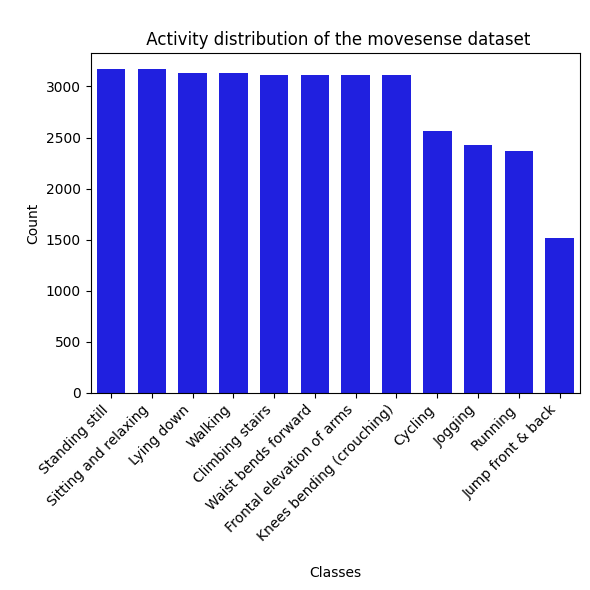

In [8]:
# Plot the number of samples present in each class_label
class_label = ['Standing still','Sitting and relaxing','Lying down','Walking', 'Climbing stairs',
               'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)',
               'Cycling','Jogging','Running','Jump front & back']
plt.figure(figsize=(6, 6)) # figure sizing 
num_of_classes = len(class_label)
# Creating barplot for the activitiy distribution in the df
sns.barplot(x=class_label, y=movement_data["classes"].value_counts(), color='b', width=0.7)
# Replace the numerical x-axis ticks with class labels
plt.xticks(range(num_of_classes), class_label, rotation=45, ha='right')
# the x_axis & y_axis labels, title
plt.xlabel('\nClasses', fontsize=10)
plt.ylabel('\nCount', fontsize=10)
plt.title("\n Activity distribution of the movesense dataset", fontsize=12)
#display plot
plt.tight_layout()
plt.show()

In [9]:
# Statistics of the dataframe
movement_data.describe().T

,count,mean,std,min,25%,50%,75%,max
x,33920.0,-0.702360,2.929547,-13.342855,-0.614977,0.023929,0.504904,14.780993
y,33920.0,8.363051,4.379716,-16.341170,7.195475,9.267733,9.705635,58.250560
z,33920.0,0.331280,3.177938,-17.343798,-0.485760,0.882983,1.943041,17.082972
gx,33920.0,-1.368102,35.945421,-220.500000,-8.190000,-0.420000,5.950000,262.990000
gy,33920.0,-11.264271,50.935629,-279.300000,-17.780000,-1.960000,1.190000,302.890000
gz,33920.0,0.383836,11.395378,-87.430000,-3.220000,0.980000,3.570000,95.760000
ecg_mV,33920.0,-0.055004,0.521145,-6.441316,-0.297674,-0.140419,0.139380,11.671988
classes,33920.0,6.198909,3.410343,1.000000,3.000000,6.000000,9.000000,12.000000


In [10]:
# Data filtering
# Columns of the dataframe to apply filtering
cols=['x', 'y', 'z','gx', 'gy', 'gz','ecg_mV']
# filtering the sensor signal from noise
# low pass filtering > remove high frequency noise
## Defining the low-pass filter parameters
cutoff_freq = 20 # hz
fs = 52  # sampling rate (Hz)
nyquist_freq = 0.5 * fs
n_order = 3 #filter_order
# Designing the Butterworth filter
b, a = butter(n_order , cutoff_freq/nyquist_freq, btype='low')
# Applying the filter to the selected data_columns
filtered_data = filtfilt(b, a,movement_data[cols].values, axis=0)
#assign the filtered data to the dataframe
filtered_movement_data= pd.DataFrame(filtered_data, columns=cols) # put the filtered data to df
filtered_movement_data['classes'] = movement_data['classes'] # assign back the labels
# Display the filtered DataFrame
filtered_movement_data.head() # display first_five rows

,x,y,z,gx,gy,gz,ecg_mV,classes
0,1.081553,9.787466,0.844288,-7.771271,-18.549670,-6.298531,-0.207754,1
1,1.130787,9.728899,0.947460,-7.906740,-20.159208,-7.835102,-0.221694,1
2,1.104429,9.659740,0.934216,-8.268473,-22.123407,-9.109029,-0.104287,1
3,1.059689,9.577807,0.923373,-8.804050,-24.423412,-10.138724,-0.250426,1
4,1.075225,9.473496,0.874841,-9.678180,-26.886830,-10.724484,0.558998,1


In [11]:
# Features and class from the dataframe
Features =filtered_movement_data.copy() #features/input
Label = Features.pop('classes') # class_labels/output

In [12]:
# Normalize the input variables
scaler = StandardScaler()
normalized_feature = scaler.fit_transform(Features)

In [13]:
# Data-Segmentation
# Creating a function for the sliding_window  
#num_time_step: which specifies the length of each segment
#step_size: which specifies the step size used to slide the window over the data
def create_sequences(X, y, num_time_step, stepsize=1): # X:input y: output
    segment, label = [],[]
    for i in range(0,len(X) - num_time_step, stepsize):
        x = X[i:(i + num_time_step)]
        labels = y[i: i + num_time_step]
        segment.append(x)
        label.append(stats.mode(labels)[0][0])
    return np.array(segment), np.array(label)

In [14]:
# Creating the data sequence 
X_seq, y_seq = create_sequences(normalized_feature, Label ,num_time_step=104, stepsize=52)
# print shape of the data
print(X_seq.shape, y_seq.shape)

(651, 104, 7) (651,)


In [15]:
# Extract window_length,number of features, number of outputs to be used in the input & ouput of the neural network
window_length,num_features,num_outputs= X_seq.shape[1], X_seq.shape[2],to_categorical(y_seq).shape[1]
print(window_length,num_features,num_outputs)

104 7 13


In [16]:
# Perform cross-validation
scores = []
# Creating the k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True) #k(n_splits)=5 >> total nos of samples/total nos of samples * % to be used as test data 
for i, (train, test) in enumerate(kfold.split(X_seq, y_seq)):
    print(f'Fold {i}:')
    print(train.shape)
    print(test.shape)
    # Convert output variables to categorical (one-hot encoding)
    y_train_seq = to_categorical(y_seq[train])
    y_test_seq = to_categorical(y_seq[test])

    # Configuring the CNN-1D_LSTM network architecture
    input_shape = (window_length, num_features)
    model = keras.Sequential([
        # Input layer
        layers.Input(input_shape),
        layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer 1
        layers.BatchNormalization(), # batch_normalization
        layers.Activation('relu'), # activation function
        # Hidden Conv Layer
        layers.Conv1D(filters=64, kernel_size=3, padding='same'), # CNN-1D layer 2
        layers.BatchNormalization(), # batch_normalization
        layers.Activation('relu'), # activation function
        # Recurrent LSTM Layers
        layers.LSTM(units=128, return_sequences=True), # LSTM layer 1
        layers.Activation('relu'), # activation function
        layers.LSTM(units=128, return_sequences=False), # LSTM layer 2
        layers.Activation('relu'), # activation function
        # Dense layers
        layers.Dense(128, activation="relu"),
        # Activation function for the output layer 'softmax' for Multi-classification
        layers.Dense(num_outputs, activation='softmax')])

    # Compiling the model
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10,
        decay_rate=0.9)
    opt = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule) #optimizer
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy'])

    # Train the model
    model.fit(X_seq[train], y_train_seq, validation_data=(X_seq[test], y_test_seq), epochs=10, batch_size=64)

    # Predicting on the testing set
    y_pred = model.predict(X_seq[test])
    # Converting predictions to class_labels
    predctd_label = np.argmax(y_pred, axis=1)
    true_label = y_seq[test]

    # Calculate accuracy score for the current fold
    fold_accuracy = accuracy_score(true_label, predctd_label)
    # Storing the accuracy score for the fold
    scores.append(fold_accuracy)

# Print the accuracy scores for each fold and finally compute the Mean accuracy
print('\n')
print(scores)
print('\n')
avg_acc = np.mean(scores)
print("Mean_Accuracy:", avg_acc)

Fold 0:
(520,)
(131,)
Epoch 1/10
9/9 [==============================] - 12s 566ms/step - loss: 2.4009 - accuracy: 0.1981 - val_loss: 2.3413 - val_accuracy: 0.1985
Epoch 2/10
9/9 [==============================] - 3s 364ms/step - loss: 1.9618 - accuracy: 0.3500 - val_loss: 1.8871 - val_accuracy: 0.4122
Epoch 3/10
9/9 [==============================] - 3s 367ms/step - loss: 1.5250 - accuracy: 0.5712 - val_loss: 1.7743 - val_accuracy: 0.2824
Epoch 4/10
9/9 [==============================] - 3s 362ms/step - loss: 1.2303 - accuracy: 0.6462 - val_loss: 1.8754 - val_accuracy: 0.4046
Epoch 5/10
9/9 [==============================] - 3s 365ms/step - loss: 1.0357 - accuracy: 0.7500 - val_loss: 0.8676 - val_accuracy: 0.8931
Epoch 6/10
9/9 [==============================] - 3s 367ms/step - loss: 0.9839 - accuracy: 0.6750 - val_loss: 1.0746 - val_accuracy: 0.6107
Epoch 7/10
9/9 [==============================] - 3s 373ms/step - loss: 0.7325 - accuracy: 0.8115 - val_loss: 0.7155 - val_accuracy: 0.79

In [17]:
# Performance of the model on the testing set
## Calculating the mean accuracy in percentage (%)
avg_accuracy_percent=avg_acc * 100
# Print the mean accuracy
print(f"Mean_Accuracy: {avg_accuracy_percent:.1f} %")

Mean_Accuracy: 79.7 %


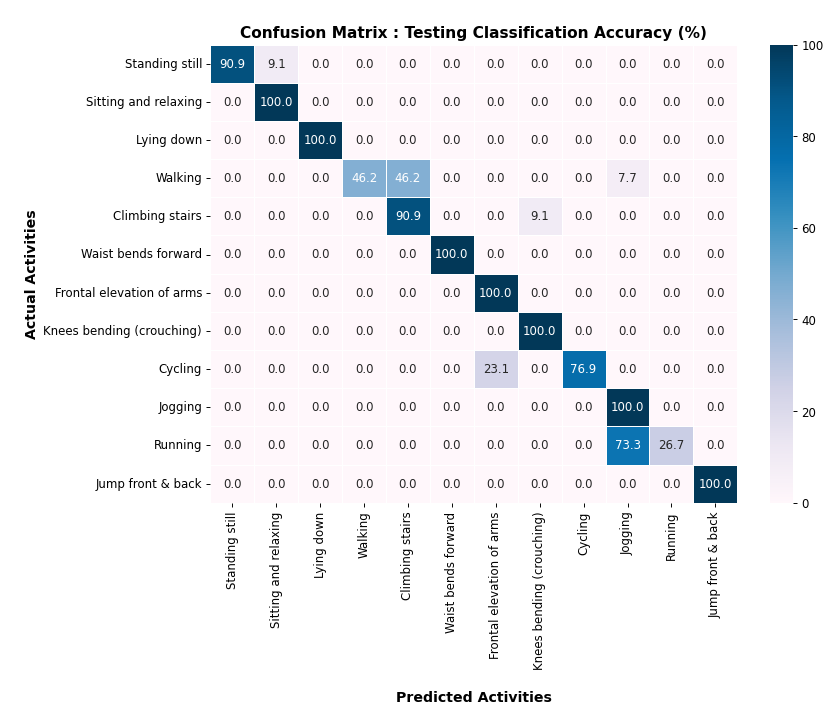

In [18]:
# Classes of the the performed activities
class_labels  = ['Standing still','Sitting and relaxing','Lying down','Walking','Climbing stairs',
                 'Waist bends forward', 'Frontal elevation of arms','Knees bending (crouching)','Cycling',
                 'Jogging','Running','Jump front & back']
# Create a confusion matrix >> test set
conf_matrix = confusion_matrix(np.argmax(y_test_seq, axis=1),predctd_label)
# Calculate accuracy percentages for each predicted class labels
class_lbl_accuracy = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
# Plot the confusion matrix with accuracy percentages
plt.figure(figsize=(10, 7), dpi=85)
sns.heatmap(class_lbl_accuracy, annot=True, fmt='.1f', cmap='PuBu', xticklabels=class_labels, yticklabels=class_labels, linewidths=0.5) #plot data
plt.title('\nConfusion Matrix : Testing Classification Accuracy (%)', fontsize=13, fontweight='bold')
plt.xlabel('\nPredicted Activities', fontsize=12, fontweight='bold')
plt.ylabel('\nActual Activities', fontsize=12, fontweight='bold')
plt.show() # display plot

- Visualize Acceleration + Gyroscope + ECG measurements

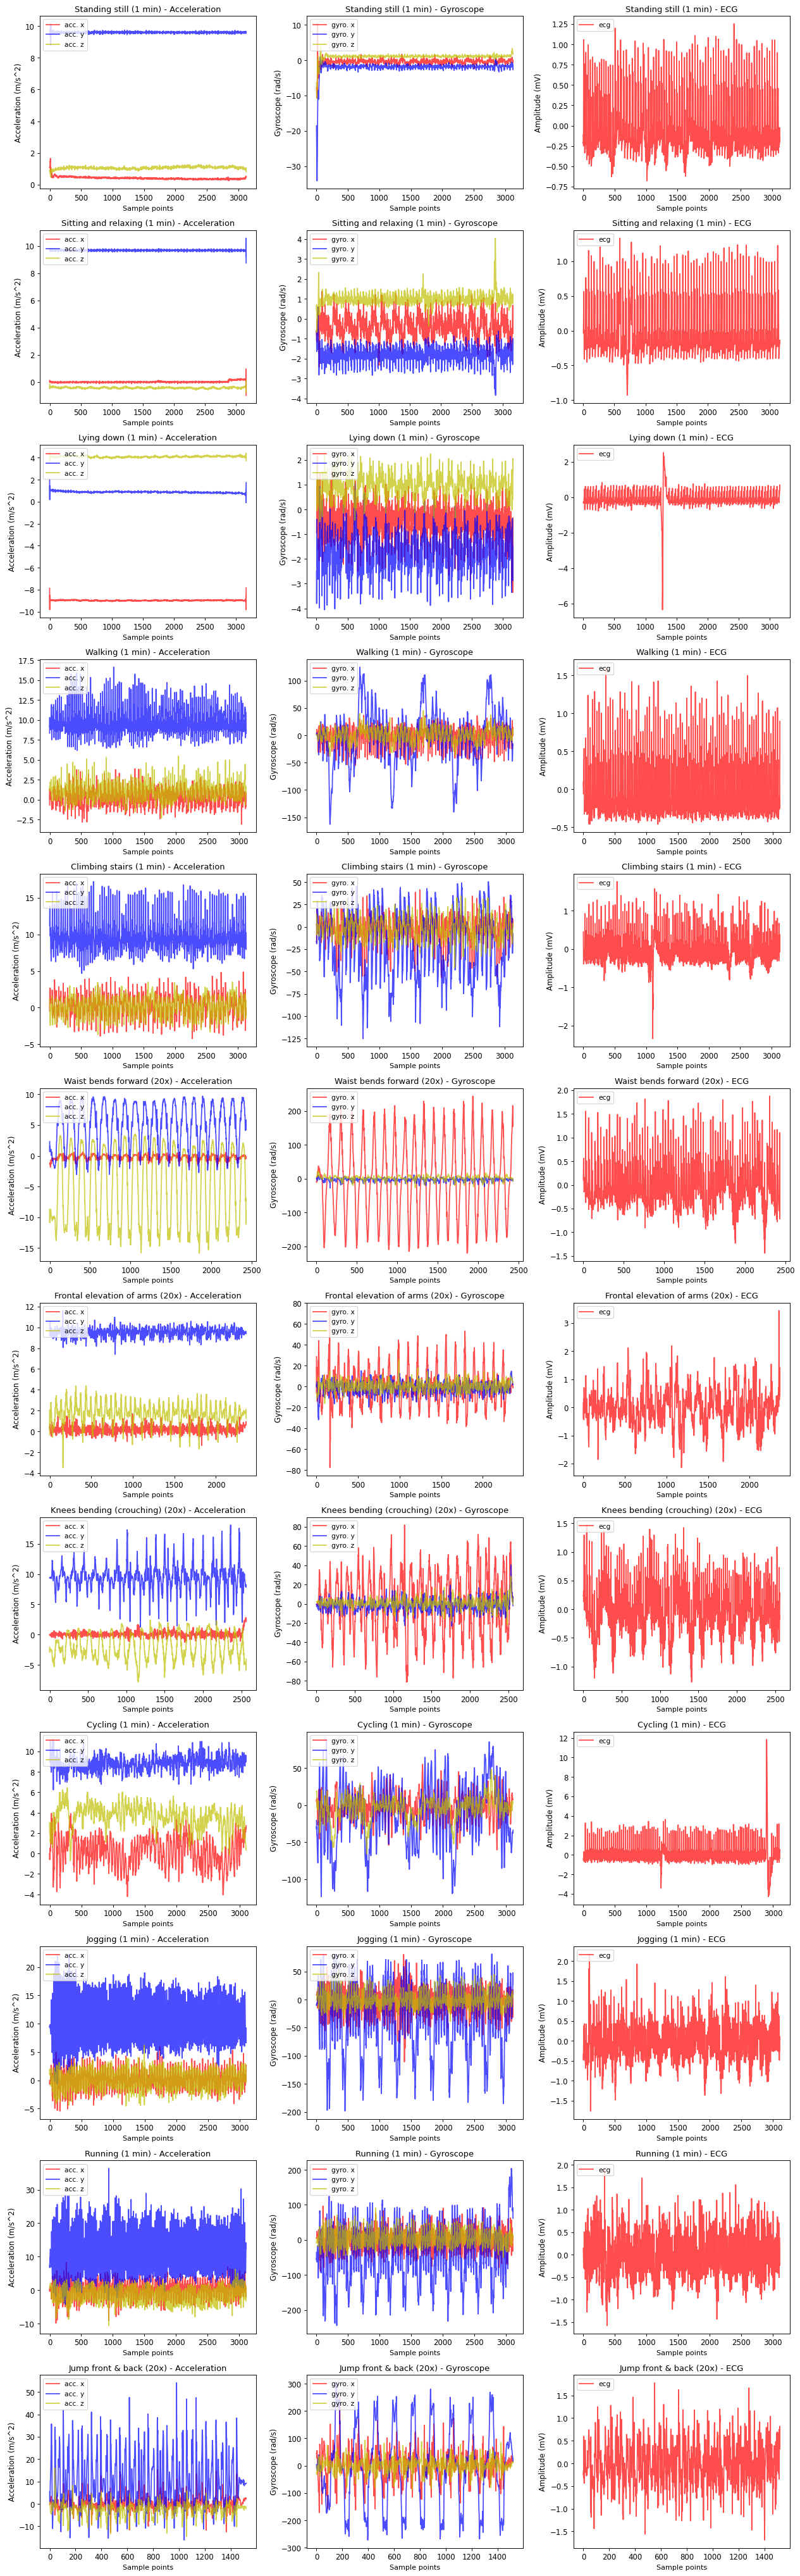

In [19]:
# Performed activities 
activity_dict = {1:'Standing still (1 min)',2:'Sitting and relaxing (1 min)',3:'Lying down (1 min)',
                4:'Walking (1 min)', 5: 'Climbing stairs (1 min)',6:'Waist bends forward (20x)',
                7:'Frontal elevation of arms (20x)',8:'Knees bending (crouching) (20x)',9:'Cycling (1 min)',
                10:'Jogging (1 min)',11:'Running (1 min)',12:'Jump front & back (20x)'}
# Determining the number of rows and columns for subplots
nos_row = len(activity_dict)
nos_col = 3  
# setting the subplots
fig, axs = plt.subplots(nos_row, nos_col, figsize=(15, 4*nos_row),dpi=85)
for i, activity_id in enumerate(activity_dict.keys()):
    # Plot accelerometer measurements for the performed activities
    axs[i, 0].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['x'], c='r', alpha=0.7)
    axs[i, 0].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['y'], c='b', alpha=0.7)
    axs[i, 0].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['z'], c='y', alpha=0.7)
    axs[i, 0].set_title(f'{activity_dict[activity_id]} - Acceleration', fontsize=11)
    axs[i, 0].set_ylabel('Acceleration (m/s^2)', fontsize=10)
    axs[i, 0].set_xlabel('Sample points', fontsize=9.5)
    axs[i, 0].legend(["acc. x", "acc. y", "acc. z"], fontsize=9, loc="upper left")
    # Plot gyroscope measurements for the performed activities
    axs[i, 1].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['gx'], c='r', alpha=0.7)
    axs[i, 1].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['gy'], c='b', alpha=0.7)
    axs[i, 1].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['gz'], c='y', alpha=0.7)
    axs[i, 1].set_title(f'{activity_dict[activity_id]} - Gyroscope', fontsize=11)
    axs[i, 1].set_ylabel('Gyroscope (rad/s)', fontsize=10)
    axs[i, 1].set_xlabel('Sample points', fontsize=9.5)
    axs[i, 1].legend(["gyro. x", "gyro. y", "gyro. z"], fontsize=9, loc="upper left")
    # Plot the ecg measurement for the performed activities
    axs[i, 2].plot(filtered_movement_data[filtered_movement_data['classes'] == activity_id].reset_index(drop=True)['ecg_mV'],c='r',alpha=0.7)
    axs[i, 2].set_xlabel('Sample points', fontsize=9.5)  # X label
    axs[i, 2].set_ylabel('Amplitude (mV)', fontsize=10)  # Y label
    axs[i, 2].set_title(f'{activity_dict[activity_id]} - ECG', fontsize=11)  # Title
    axs[i, 2].legend(["ecg"], fontsize=9, loc="upper left")
# Adjust the layout  
plt.tight_layout()
plt.show() #display plots